<a href="https://colab.research.google.com/github/JordanDCunha/comp215/blob/main/zombie-sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project: Zombie Apocalypse

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
from pprint import pprint
import matplotlib.animation as animation
from scipy.signal import correlate2d
import matplotlib.animation as animation

import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/Cell2D.py

from Cell2D import Cell2D, draw_array
from matplotlib.animation import FuncAnimation
import random
from IPython.display import HTML

1. Animation2D Class

In [ ]:
class Animation2D:
    def __init__(self, model, frames=100, steps_per_frame=1, figsize=(8, 8)):
        self.model = model           # the simulation
        self.frames = frames         # number of animation frames
        self.steps_per_frame = steps_per_frame # number of simulation steps to take before making new frame
        self.fig, self.ax = plt.subplots(figsize=figsize) # figure and axis used for drawing

    def animation_step(self, step):
        '''Sets up animated visualization

        '''
        for _ in range(self.steps_per_frame):
            self.model.step() # Called repeatedly to draw updated model
        self.model.draw()

    def show(self):
        '''Advances simulation and draws each frame

        '''
        anim = animation.FuncAnimation(self.fig, self.animation_step,
                                       frames=self.frames, repeat=False) # Generate an animation objects
        plt.close()
        return anim

    def animate(self, interval=None):
        '''Returns a reusable animation object

        '''
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)
                self.ax.clear()
                plt.figure(self.fig)
                self.animation_step(i)
                plt.show()
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [ ]:
def make_locs(n, m):
    '''Generates a flat grid of (x, y) coordinates

    '''
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

def make_visible_locs(vision):
    '''Returns all nearby cells up to vision steps in all cardinal directions

    '''
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

def distances_from(n, i, j):
    '''Returns a matrix of Euclidean distances from a specific point (i, j)

    '''
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [ ]:
class Agent:
    def __init__(self, pos, is_human=True):
        self.pos = pos
        self.is_human = is_human

    def move(self, grid, size, agents, vision=5, capacity=None, bogs=None):
        if self.is_human:
            target_pos = self.get_closest_target(agents)
            speed = 1
            self.pos = self.look_and_move(self.pos, vision, target_pos, size, speed)
        else:
            if self.frozen:
                self.frozen_turns -= 1
                if self.frozen_turns <= 0:
                    self.thaw()
                else:
                    return
            elif bogs is not None and self.is_on_bog(bogs):
                self.frozen_turns = 3
                self.frozen = True
                return
            target_pos = self.get_closest_target(agents)
            current_pos = self.pos
            x, y = current_pos
            speed = self.get_speed_at_position(x, y, capacity)
            self.pos = self.look_and_move(current_pos, vision, target_pos, size, speed)

    def get_closest_target(self, agents):
        closest_target = None
        min_distance = float('inf')
        for agent in agents:
            if self.is_human == agent.is_human:
                continue
            distance = np.linalg.norm(np.array(self.pos) - np.array(agent.pos))
            if distance < min_distance:
                closest_target = agent.pos
                min_distance = distance
        return closest_target

    def look_and_move(self, current_pos, vision, target_pos, size, speed):
          x, y = current_pos
          valid_moves = self.get_valid_moves(x, y, size)
          if not valid_moves:
              return current_pos
          if target_pos is None:
              return random.choice(valid_moves)
          if self.is_human:
              best_move = max(valid_moves, key=lambda m: np.linalg.norm(np.array(m) - np.array(target_pos)))
          else:
            if speed > 1:
                best_move = self.get_best_move_for_speed(current_pos, target_pos, size, speed)
            else:
                best_move = min(valid_moves, key=lambda m: np.linalg.norm(np.array(m) - np.array(target_pos)))
          return best_move

    def get_valid_moves(self, x, y, size):
        directions = [
            (x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
            (x + 1, y + 1), (x - 1, y - 1), (x + 1, y - 1), (x - 1, y + 1)
        ]
        return [(mx, my) for (mx, my) in directions if 0 <= mx < size and 0 <= my < size]

class Human(Agent):
    def __init__(self, pos):
        super().__init__(pos, is_human=True)

class Zombie(Agent):
    def __init__(self, pos):
        super().__init__(pos, is_human=False)
        self.frozen = False
        self.frozen_turns = 0

    def thaw(self):
        self.frozen = False
        self.frozen_turns = 0

    def is_on_bog(self, bogs):
        x, y = self.pos
        return bogs[x, y] == 1

    def get_speed_at_position(self, x, y, capacity):
        terrain_value = capacity[x, y]
        if terrain_value == 0:
            return 100
        elif terrain_value == 1:
            return 100
        elif terrain_value == 2:
            return 100
        else:
            return 1

    def get_best_move_for_speed(self, current_pos, target_pos, size, speed):
        direction = np.array(target_pos) - np.array(current_pos)
        norm = np.linalg.norm(direction)
        if norm == 0:
            return current_pos
        direction = direction / norm
        new_pos = np.array(current_pos)
        for _ in range(speed):
            step = np.round(direction).astype(int)
            new_pos += step
            new_pos[0] = np.clip(new_pos[0], 0, size - 1)
            new_pos[1] = np.clip(new_pos[1], 0, size - 1)
        return tuple(new_pos)

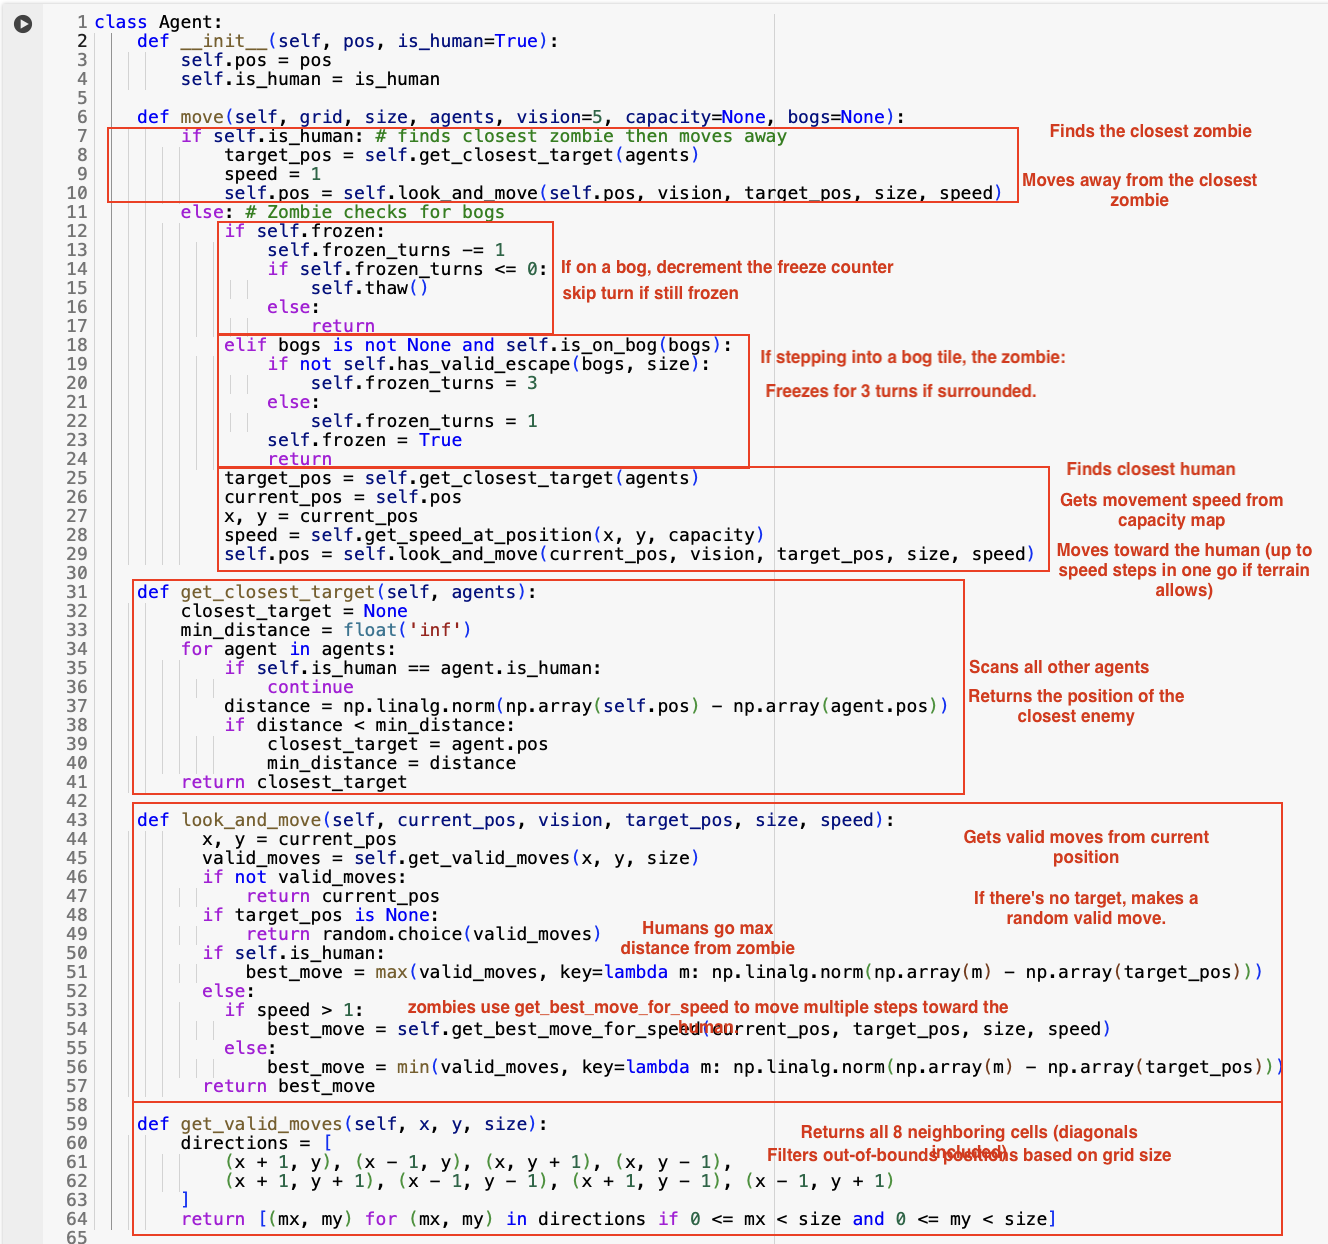

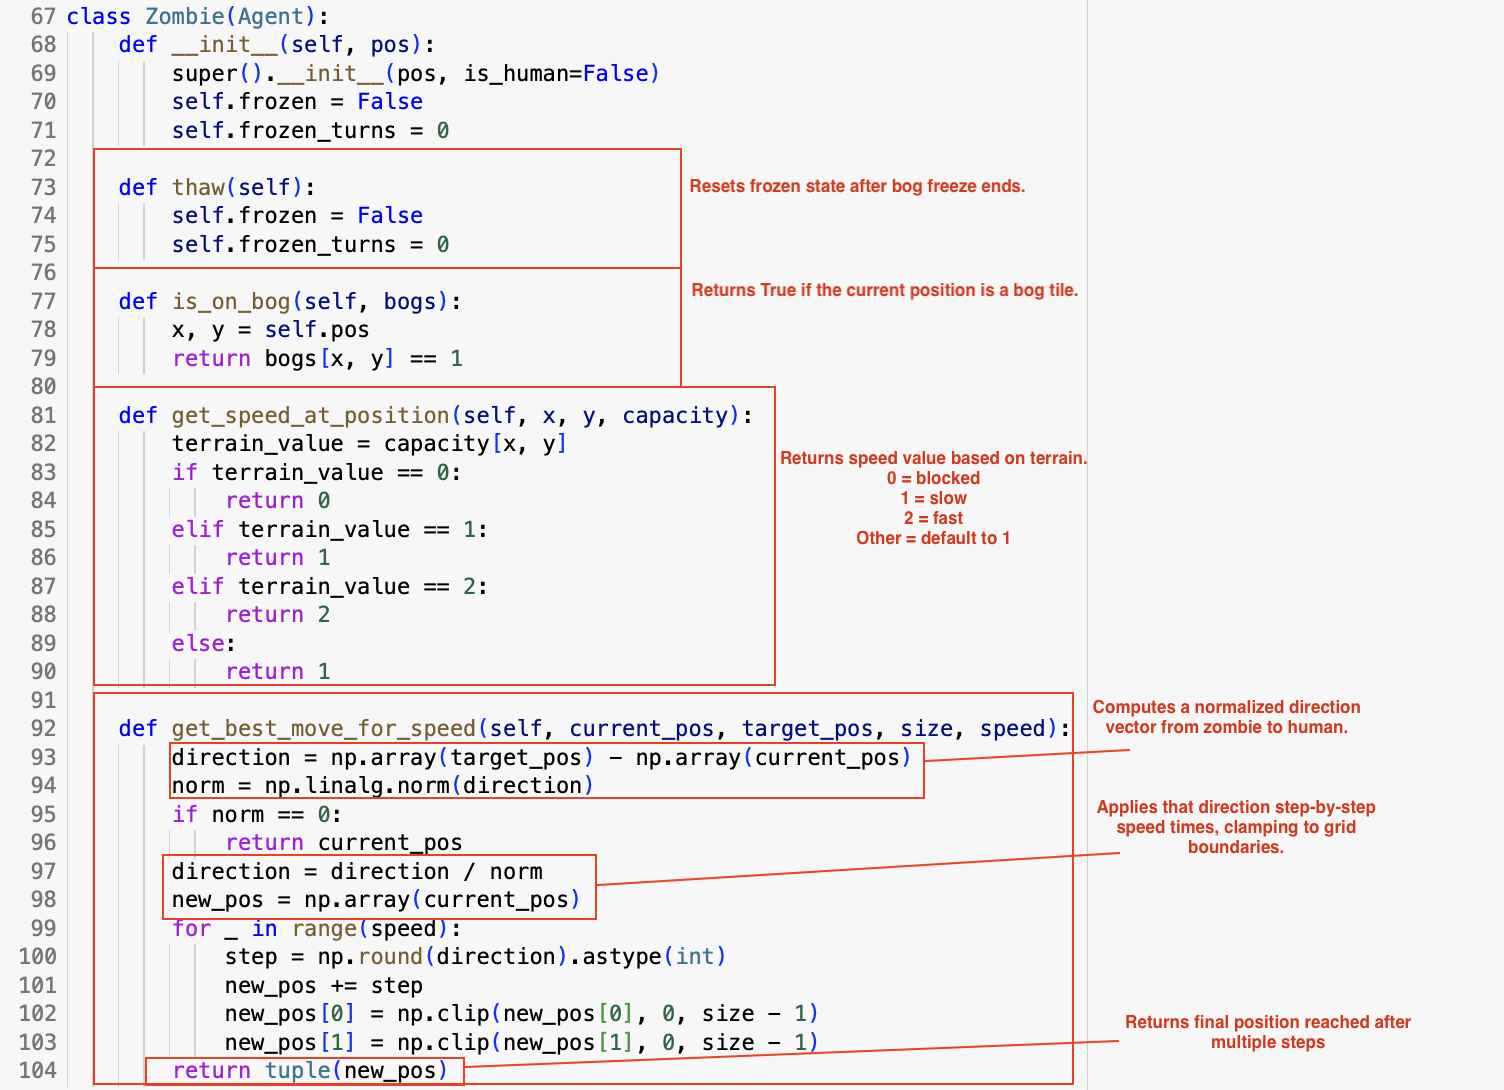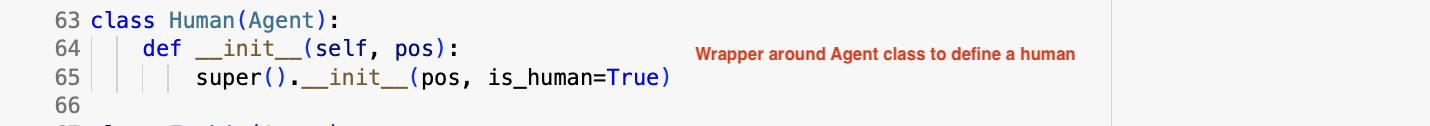

In [ ]:
class Sugarscape(Cell2D):
    def __init__(self, size, num_humans, num_zombies, human_prob, mine_prob, bog_prob, vision=5):
        self.size = size
        self.vision = vision
        self.add_human_prob = human_prob
        self.mine_spawn_prob = mine_prob
        self.bog_percentage = bog_prob
        super().__init__(size, size)
        self.agent_layer = np.zeros((self.size, self.size), dtype=int)

        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()

        self.humans = []
        self.zombies = []
        self.landmines = np.zeros((self.size, self.size), dtype=int)
        self.bogs = np.zeros((self.size, self.size), dtype=int)

        self.populate_agents(Human, num_humans, self.humans)
        self.populate_agents(Zombie, num_zombies, self.zombies)

        self.frame_count = 0

        self.spawn_bogs()

    def make_locs(size_x, size_y):
        locs = [(x, y) for x in range(size_x) for y in range(size_y)]
        random.shuffle(locs)
        return locs

    def make_capacity(self):
        dist1 = distances_from(self.size, 5, 5)
        dist2 = distances_from(self.size, 15, 15)
        dist = np.minimum(dist1, dist2)
        bins = [21, 16, 11, 6]
        return np.digitize(dist, bins)

    def populate_agents(self, agent_cls, count, container):
        locs = make_locs(self.size, self.size)
        np.random.shuffle(locs)
        for i in range(count):
            pos = tuple(locs[i])
            while self.is_bog(pos):
                pos = tuple(locs[i])

            container.append(agent_cls(pos))
            self.agent_layer[pos] = 1 if agent_cls == Human else 2
    def add_random_human(self):
        empty_locs = [(x, y) for x in range(self.size) for y in range(self.size)
                      if self.agent_layer[x, y] == 0 and self.landmines[x, y] == 0]
        if empty_locs:
            pos = random.choice(empty_locs)
            new_human = Human(pos)
            self.humans.append(new_human)
            self.agent_layer[pos] = 1  # Mark the cell as occupied by a human

    def spawn_random_mine(self):
        empty_locs = [(x, y) for x in range(self.size) for y in range(self.size)
                      if self.agent_layer[x, y] == 0 and self.landmines[x, y] == 0]
        if empty_locs:
            x, y = random.choice(empty_locs)
            self.landmines[x, y] = 1

    def spawn_bogs(self):
        total_cells = self.size * self.size
        bog_count = int(total_cells * self.bog_percentage)

        bog_cells = random.sample(range(total_cells), bog_count)

        for idx in bog_cells:
            x = idx // self.size
            y = idx % self.size
            if self.agent_layer[x, y] == 0 and self.landmines[x, y] == 0:
                if x + 2 < self.size and y + 2 < self.size:
                    self.bogs[x:x+3, y:y+3] = 1

    def is_bog(self, pos):
        """Check if a position is part of a bog."""
        x, y = pos
        return np.any(self.bogs[x:x+3, y:y+3] == 1)

    def is_empty_area(self, x, y):
        """Check if a 3x3 area is empty (no humans, zombies, landmines, or bogs)."""
        return np.all(self.array[x:x+3, y:y+3] == 0) and np.all(self.bogs[x:x+3, y:y+3] == 0)



    def update_grid(self):
        self.agent_layer[:] = 0
        for h in self.humans:
            self.agent_layer[h.pos] = 1
        for z in self.zombies:
            self.agent_layer[z.pos] = 2

        self.array = self.capacity.copy()
        self.array[self.agent_layer == 1] = 1
        self.array[self.agent_layer == 2] = 2

    def draw(self):
        bog_count = np.sum(self.bogs == 1)

        title = f"Zombies: {len(self.zombies)} | Humans: {len(self.humans)} | Bogs: {bog_count} | Frames: {self.frame_count}"

        plt.title(title, fontsize=16)
        plt.imshow(self.array, cmap='YlOrRd', origin='lower', interpolation='none',
                  vmin=0, vmax=4, extent=[0, self.size, 0, self.size])

        for h in self.humans:
            plt.plot(h.pos[1] + 0.5, h.pos[0] + 0.5, 'bo')

        for z in self.zombies:
            plt.plot(z.pos[1] + 0.5, z.pos[0] + 0.5, 'ro')

        mine_xs, mine_ys = np.where(self.landmines == 1)
        plt.scatter(mine_ys + 0.5, mine_xs + 0.5, color='yellow', marker='*', s=100)

        bog_xs, bog_ys = np.where(self.bogs == 1)
        plt.scatter(bog_ys + 0.5, bog_xs + 0.5, color='cyan', marker='.', s=100, alpha=0.5)

        plt.xticks([])
        plt.yticks([])

    def step(self):
        for h in self.humans:
            h.infected = False
            h.move(self.array, self.size, self.zombies, self.vision)

        for z in self.zombies:
            z.move(self.array, self.size, self.humans, self.vision, capacity=self.capacity, bogs=self.bogs)
            zx, zy = z.pos
            for h in self.humans:
                hx, hy = h.pos
                if abs(zx - hx) <= 1 and abs(zy - hy) <= 1:
                    h.infected = True

        # Infections
        new_zombies = [Zombie(h.pos) for h in self.humans if h.infected]
        self.humans = [h for h in self.humans if not h.infected]
        self.zombies.extend(new_zombies)

        # Mine detonations: remove zombies that stepped on mines
        detonated_zombies = [z for z in self.zombies if self.landmines[z.pos] == 1]
        self.zombies = [z for z in self.zombies if self.landmines[z.pos] == 0]

        # Optional: remove the mine after detonation
        for z in detonated_zombies:
            self.landmines[z.pos] = 0

        # Randomly spawn new human
        if random.random() < self.add_human_prob:
            self.add_random_human()

        # Randomly spawn new landmine
        if random.random() < self.mine_spawn_prob:
            self.spawn_random_mine()

        self.update_grid()

        self.frame_count += 1  # Increment the frame count each step

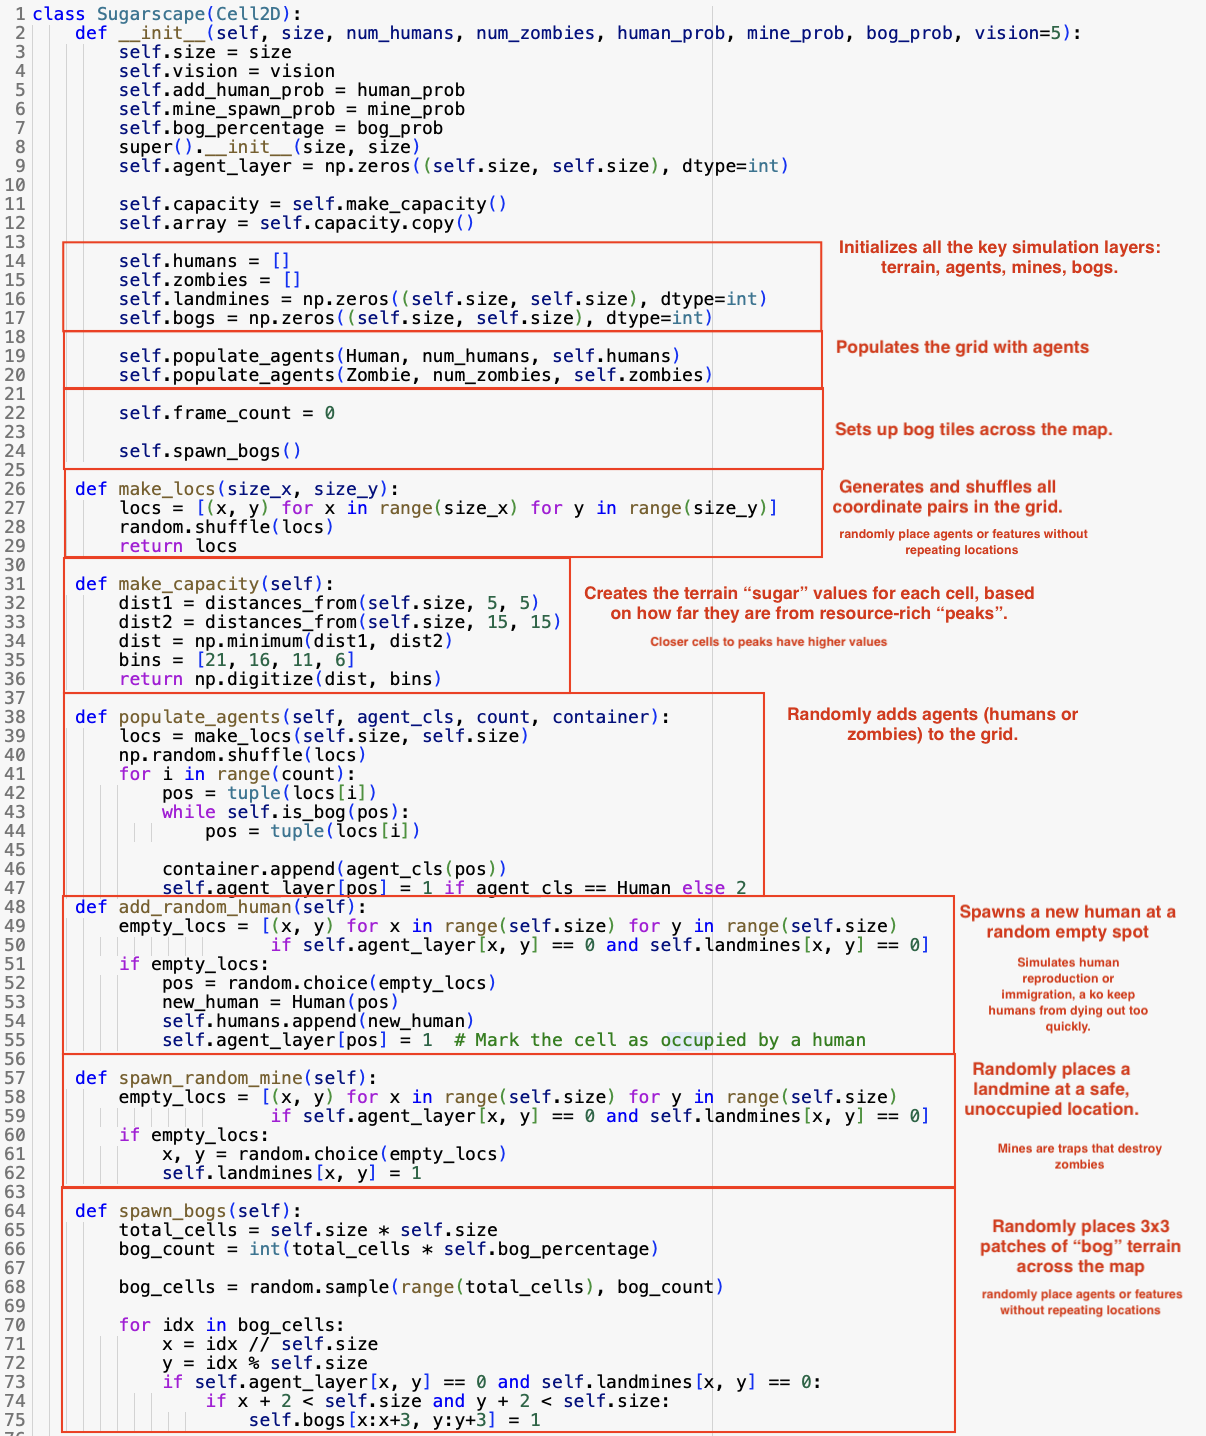

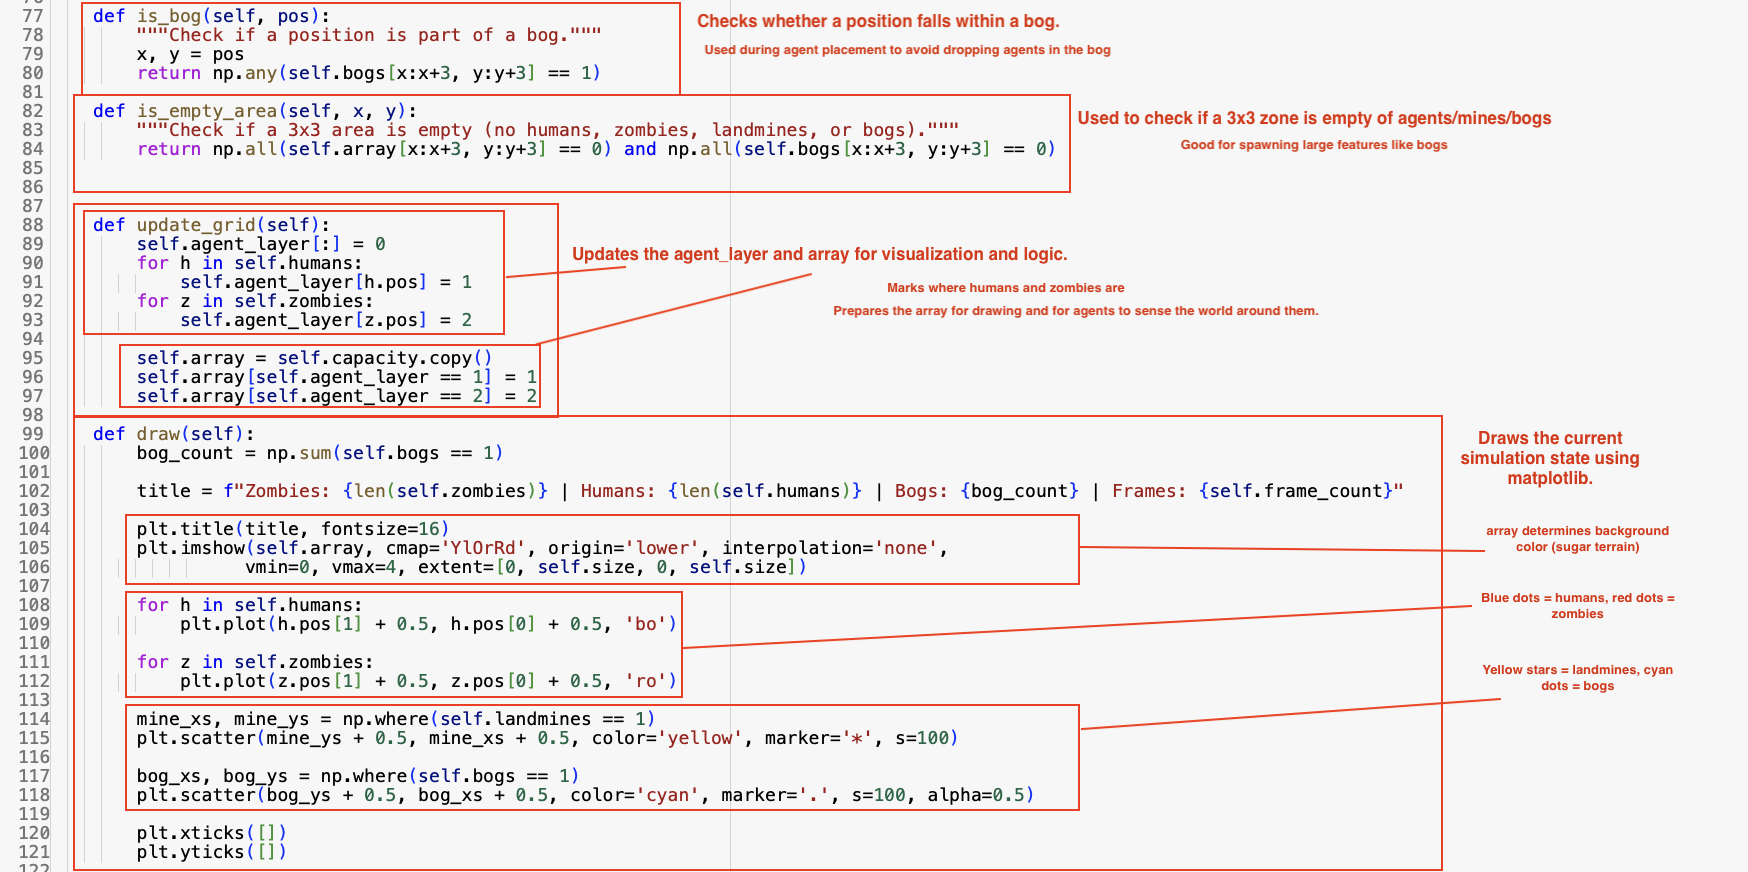

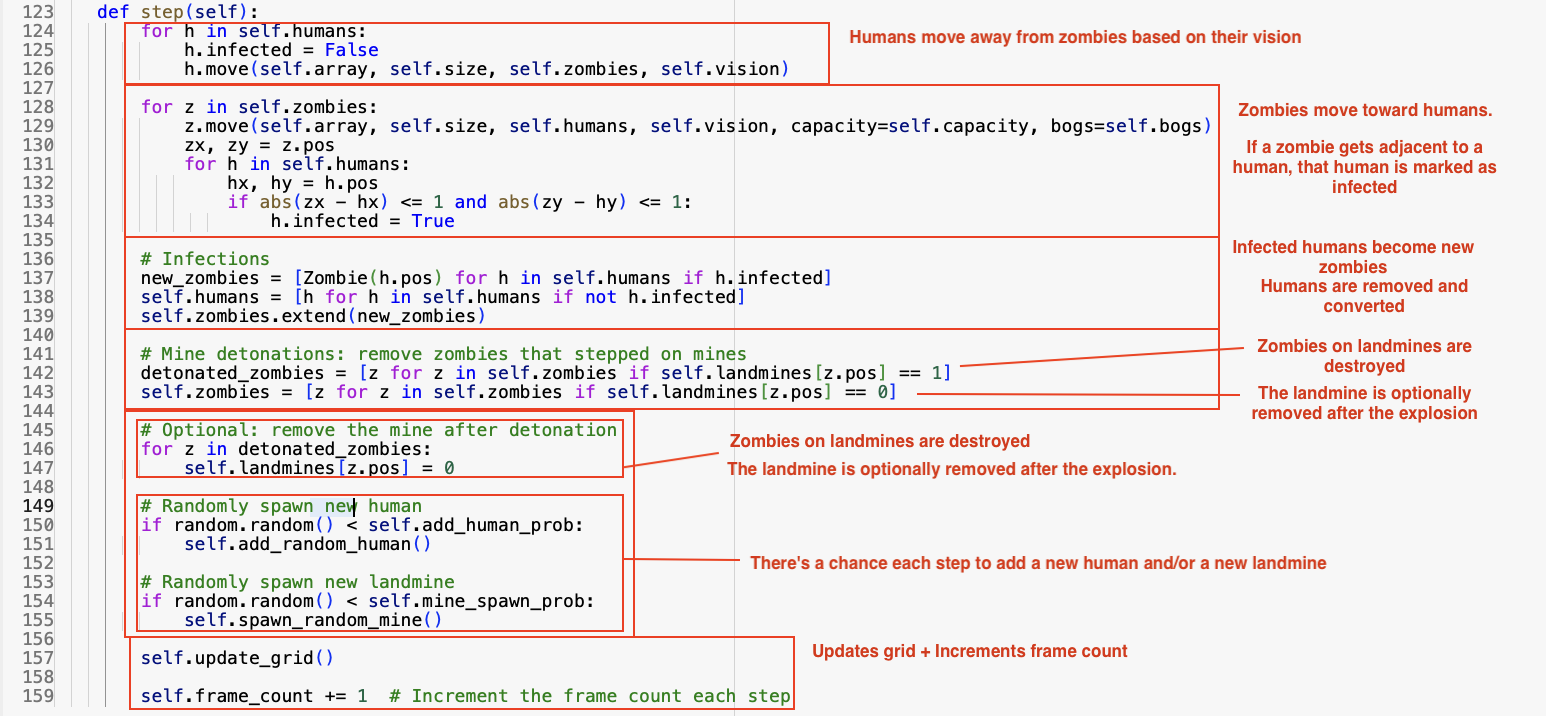

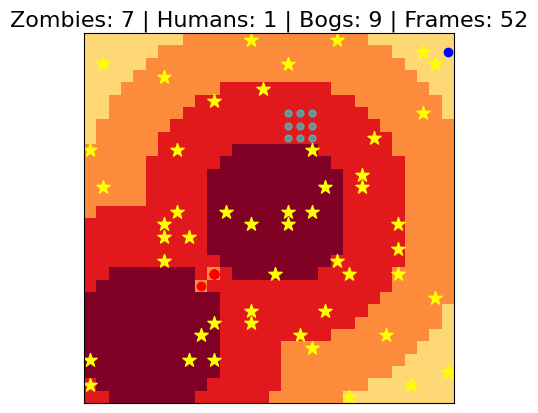

In [ ]:
fig, ax = plt.subplots()

# Initialize your Sugarscape model
model = Sugarscape(size=30, num_humans=5, num_zombies=5, human_prob=0, mine_prob=1, bog_prob=0.002)

# Define the update function for the animation
def update(frame):
    model.step()  # Update the model with each step
    ax.clear()  # Clear the axis
    model.draw()  # Draw the new state of the simulation

# Create the animation
anim = FuncAnimation(fig, update, frames=50, repeat=False)

# Display the animation as HTML
HTML(anim.to_jshtml())

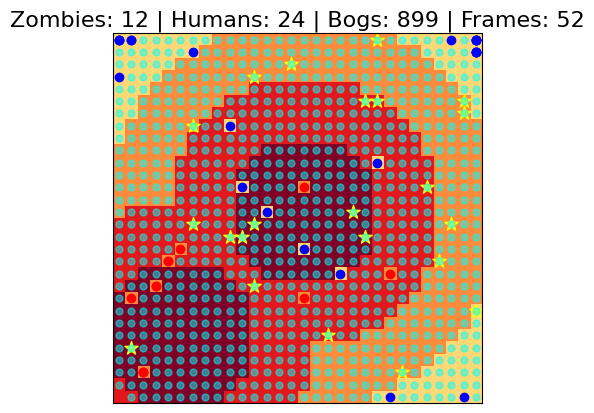

In [ ]:
fig, ax = plt.subplots()

# Initialize your Sugarscape model
model = Sugarscape(size=30, num_humans=2, num_zombies=10, human_prob=0.5, mine_prob=0.5, bog_prob=1.0)

# Define the update function for the animation
def update(frame):
    model.step()  # Update the model with each step
    ax.clear()  # Clear the axis
    model.draw()  # Draw the new state of the simulation

# Create the animation
anim = FuncAnimation(fig, update, frames=50, repeat=False)

# Display the animation as HTML
HTML(anim.to_jshtml())

# Question 1 - What will be the tipping point for number of humans to overpower 10 zombies


Hypothesises:

1. If the number of bogs and landmines are luck-based then the chances that humans overpower the zombies will also be luck-based because the number of landmines will vary from simulation to simulation
2. If the simulation begins with a greater amount of humans then the chances that there will be more humans by the end because the zombies will be overwhelmed by the number of humans and the respawn rate will only provide a greater amount of humans

In [ ]:
def run_trial(size, num_humans, num_zombies, human_prob, mine_prob, bog_prob, vision, steps):
    sim = Sugarscape(size, num_humans, num_zombies, human_prob, mine_prob, bog_prob, vision)
    for _ in range(steps):
        sim.step()
    return len(sim.humans), len(sim.zombies)

def average_difference_over_trials(trials=5, **kwargs):
    human_counts = []
    zombie_counts = []
    for _ in range(trials):
        h, z = run_trial(**kwargs)
        human_counts.append(h)
        zombie_counts.append(z)
    diffs = [abs(h - z) for h, z in zip(human_counts, zombie_counts)]
    return np.mean(diffs), np.mean(human_counts), np.mean(zombie_counts)

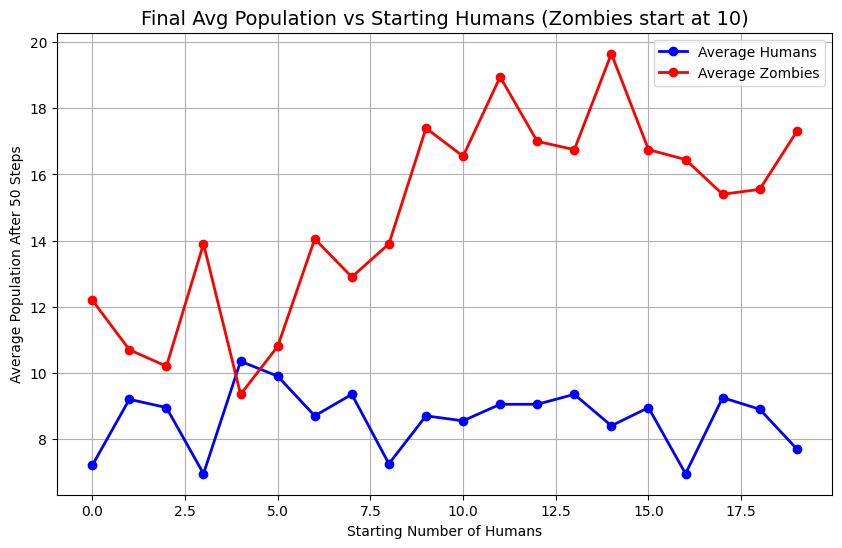


🧠 Human-start values where humans win on average:
[4]


In [ ]:
humans_range = [i for i in range(20)]
z_start = 10  # Fixed number of starting zombies

avg_humans = []
avg_zombies = []
winning_human_starts = []

for h_start in humans_range:
    avg_diff, avg_h, avg_z = average_difference_over_trials(
        size=20,
        num_humans=h_start,
        num_zombies=z_start,
        human_prob=0.5,
        mine_prob=0.5,
        bog_prob=0.002,
        vision=5,
        steps=50,
        trials=20
    )
    avg_humans.append(avg_h)
    avg_zombies.append(avg_z)
    if avg_h > avg_z:
        winning_human_starts.append(h_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(humans_range, avg_humans, label='Average Humans', marker='o', color='blue')
plt.plot(humans_range, avg_zombies, label='Average Zombies', marker='o', color='red')

plt.title(f"Final Avg Population vs Starting Humans (Zombies start at {z_start})", fontsize=14)
plt.xlabel("Starting Number of Humans")
plt.ylabel("Average Population After 50 Steps")
plt.legend()
plt.grid(True)
plt.show()

print("\n🧠 Human-start values where humans win on average:")
print(winning_human_starts)

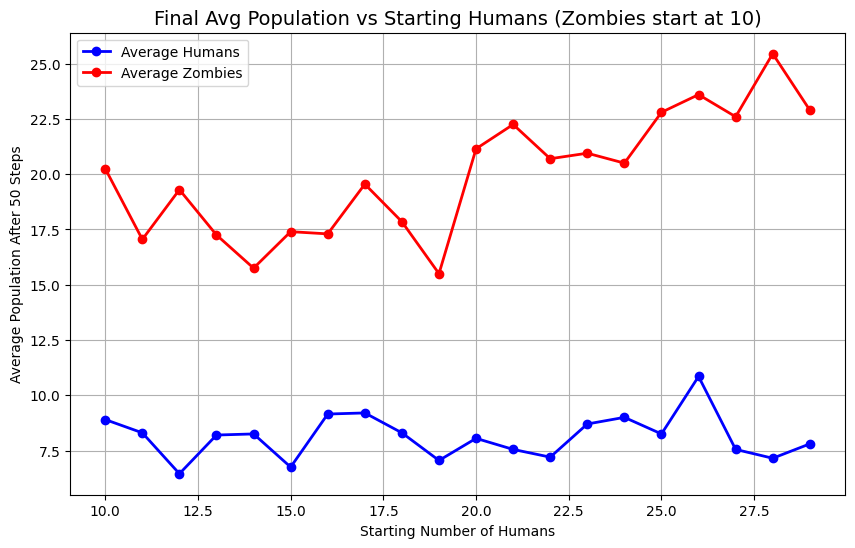


🧠 Human-start values where humans win on average:
[]


In [ ]:
humans_range = [i+10 for i in range(20)]
z_start = 10  # Fixed number of starting zombies

avg_humans = []
avg_zombies = []
winning_human_starts = []

for h_start in humans_range:
    avg_diff, avg_h, avg_z = average_difference_over_trials(
        size=20,
        num_humans=h_start,
        num_zombies=z_start,
        human_prob=0.5,
        mine_prob=0.5,
        bog_prob=0.002,
        vision=5,
        steps=50,
        trials=20
    )
    avg_humans.append(avg_h)
    avg_zombies.append(avg_z)
    if avg_h > avg_z:
        winning_human_starts.append(h_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(humans_range, avg_humans, label='Average Humans', marker='o', color='blue')
plt.plot(humans_range, avg_zombies, label='Average Zombies', marker='o', color='red')

plt.title(f"Final Avg Population vs Starting Humans (Zombies start at {z_start})", fontsize=14)
plt.xlabel("Starting Number of Humans")
plt.ylabel("Average Population After 50 Steps")
plt.legend()
plt.grid(True)
plt.show()

print("\n🧠 Human-start values where humans win on average:")
print(winning_human_starts)

# Question 2 - What if the entire grid are bogs?

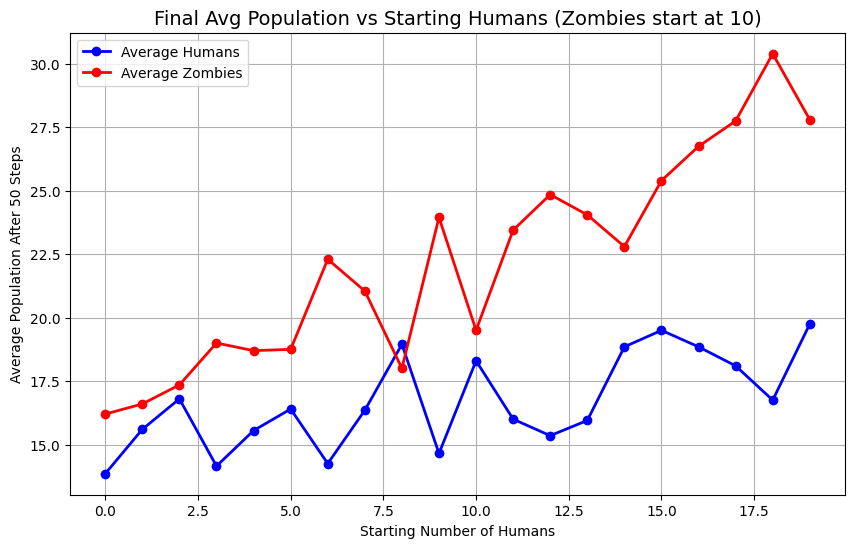


🧠 Human-start values where humans win on average:
[8]


In [ ]:
humans_range = [i for i in range(20)]
z_start = 10  # Fixed number of starting zombies

avg_humans = []
avg_zombies = []
winning_human_starts = []

for h_start in humans_range:
    avg_diff, avg_h, avg_z = average_difference_over_trials(
        size=20,
        num_humans=h_start,
        num_zombies=z_start,
        human_prob=0.5,
        mine_prob=0.5,
        bog_prob=1.0,
        vision=5,
        steps=50,
        trials=20
    )
    avg_humans.append(avg_h)
    avg_zombies.append(avg_z)
    if avg_h > avg_z:
        winning_human_starts.append(h_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(humans_range, avg_humans, label='Average Humans', marker='o', color='blue')
plt.plot(humans_range, avg_zombies, label='Average Zombies', marker='o', color='red')

plt.title(f"Final Avg Population vs Starting Humans (Zombies start at {z_start})", fontsize=14)
plt.xlabel("Starting Number of Humans")
plt.ylabel("Average Population After 50 Steps")
plt.legend()
plt.grid(True)
plt.show()

print("\n🧠 Human-start values where humans win on average:")
print(winning_human_starts)

# Question 3 - What if the humans cannot respawn?

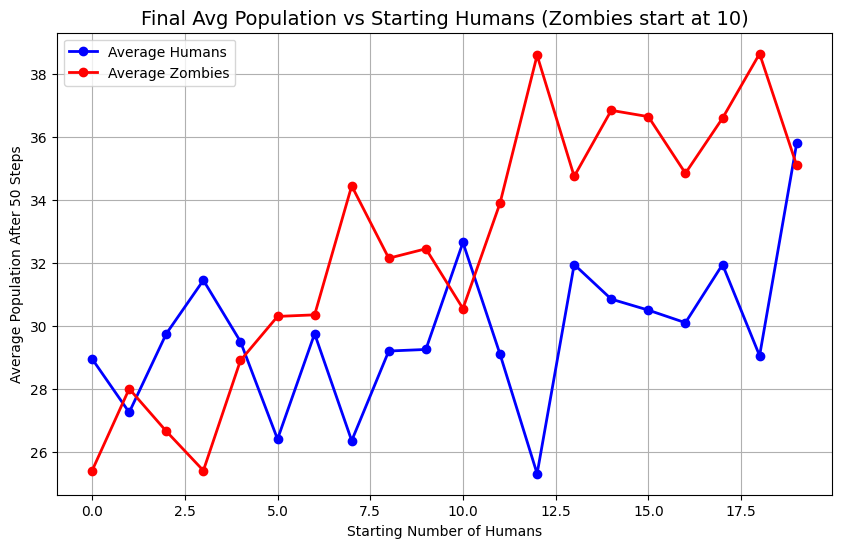


🧠 Human-start values where humans win on average:
[0, 2, 3, 4, 10, 19]


In [ ]:
humans_range = [i for i in range(20)]
z_start = 10  # Fixed number of starting zombies

avg_humans = []
avg_zombies = []
winning_human_starts = []

for h_start in humans_range:
    avg_diff, avg_h, avg_z = average_difference_over_trials(
        size=20,
        num_humans=h_start,
        num_zombies=z_start,
        human_prob=1,
        mine_prob=0.5,
        bog_prob=1.0,
        vision=5,
        steps=50,
        trials=20
    )
    avg_humans.append(avg_h)
    avg_zombies.append(avg_z)
    if avg_h > avg_z:
        winning_human_starts.append(h_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(humans_range, avg_humans, label='Average Humans', marker='o', color='blue')
plt.plot(humans_range, avg_zombies, label='Average Zombies', marker='o', color='red')

plt.title(f"Final Avg Population vs Starting Humans (Zombies start at {z_start})", fontsize=14)
plt.xlabel("Starting Number of Humans")
plt.ylabel("Average Population After 50 Steps")
plt.legend()
plt.grid(True)
plt.show()

print("\n🧠 Human-start values where humans win on average:")
print(winning_human_starts)

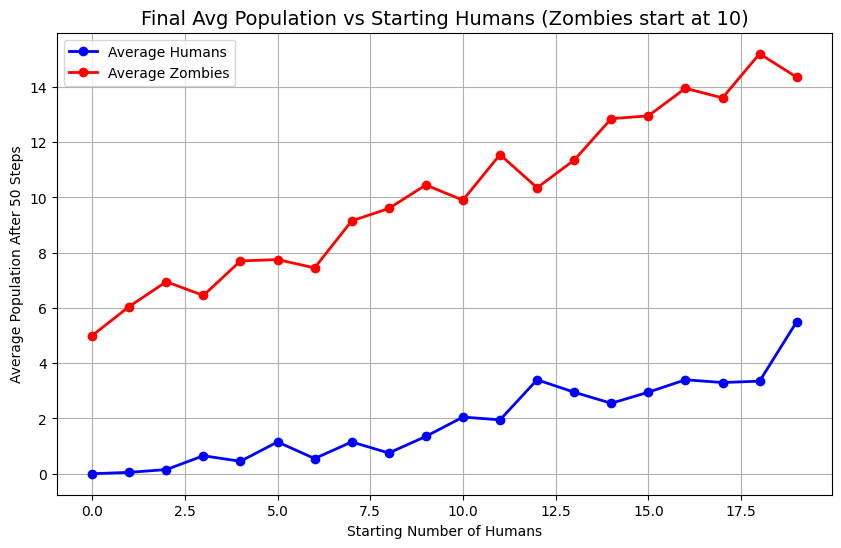


🧠 Human-start values where humans win on average:
[]


In [ ]:
humans_range = [i for i in range(20)]
z_start = 10  # Fixed number of starting zombies

avg_humans = []
avg_zombies = []
winning_human_starts = []

for h_start in humans_range:
    avg_diff, avg_h, avg_z = average_difference_over_trials(
        size=20,
        num_humans=h_start,
        num_zombies=z_start,
        human_prob=0,
        mine_prob=1,
        bog_prob=1.0,
        vision=5,
        steps=50,
        trials=20
    )
    avg_humans.append(avg_h)
    avg_zombies.append(avg_z)
    if avg_h > avg_z:
        winning_human_starts.append(h_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(humans_range, avg_humans, label='Average Humans', marker='o', color='blue')
plt.plot(humans_range, avg_zombies, label='Average Zombies', marker='o', color='red')

plt.title(f"Final Avg Population vs Starting Humans (Zombies start at {z_start})", fontsize=14)
plt.xlabel("Starting Number of Humans")
plt.ylabel("Average Population After 50 Steps")
plt.legend()
plt.grid(True)
plt.show()

print("\n🧠 Human-start values where humans win on average:")
print(winning_human_starts)